# To Do

- Explain where HITL file `annotations.csv` file came from
    - Mike suggests:  https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find
    - Mike adds: https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find?refdes=RS03AXBS-LJ03A-05-HPIESA301&beginDT=1391865279000&endDT=1659393179000
    - need creds for these
- HITL make sure covers 2018 and 2021; and pitch 2019
- Very much gloss over the profile business
- What equilibrates? Nitrate? I think it might be pH...
- All figures need axis labels
- Double check std applied to fig 6 is based on filtered data (error bars disabled ATM)
- NPQ flagging: Annotation or temporary redaction?
    - FC: NPQ flag before matching to discrete data to avoid overfit bias. 
    - Temporarily remove quenched data in comparison with discrete sample data.
- Big dataset Save operations should reduce volume by discarding unused Data Variables first



# Introduction and Overview

## Key links

This notebook conforms to the OOI data quality
[flowchart](https://docs.google.com/drawings/d/1CYWFAGMNZQa8W3xFslrI9uXyHW78q24KhBOhiTMUz98)
and
[pseudo-code document](https://docs.google.com/document/d/1gQhFzkthh-S116F_p32hoF_uw22MB3mKF3DKyUtmIxw)
for Bio-optics data quality guidelines.
Full-resolution data downloads are available via the OOI Data Explorer; see for example
[this link](https://dataexplorer.oceanobservatories.org/#metadata/104289/station/2000/sensor/downloads).


* [OOI Quality Control](https://ooi-website.whoi.edu/quality-control/)
* [OOI Data](https://oceanobservatories.org/tag/data/)
* [OOI Data Explorer](https://dataexplorer.oceanobservatories.org/#ooi/array/RS/platform_type/profiling-assets/annotations?instrument_type_id=FLUOR)
* [Notebook: OOI QC flags by Peter Cable](https://github.com/petercable/shared_notebooks/blob/master/qc_flags/qc_flags.ipynb)
* [Notebook: OOI Data Explorer and Python by Chris Wingard](https://github.com/oceanobservatories/ooi-data-explorations/tree/master/python)
* [Notebook: HITL (Human In The Loop) by Chris Wingard](https://github.com/oceanobservatories/ooi-data-explorations/blob/master/python/examples/notebooks/dosta/ooiea_dosta_annotations_hitl_qc.ipynb)





## Notebook mechanics


### NB-Mech 1: Directory structure for this repository


There are three file locations to be aware of when using this repository.


- The repository root directory: Includes this notebook
- Sub-folders within this repositor e.g. the **`Discrete Summaries`** folder
- Parent directory external to this repository **`../`**: Includes **`../data`**
    - Repository size is limited; larger datasets (> 100MB) are located externally
    - Example: **`../data/rca/fluor/osb/2021/flort_fullres.nc`** 
    - Also in the parent directory: Resource folder **`BOS`** for Bio-Optics Source
        - **`../BOS`** content is described below


### NB-Mech 2: Python helper code


This notebook uses 'helper' Python code located in `DataQualityGuideModule.py`
(root folder).


### NB-Mech 3: Saving datasets


Datasets have been saved to a dedicated folder external to this repository.
Save operations are found in dedicated Python that begin with a **`# Save`** comment.
Discrete summary CSV tables are saved in **`../BOS/DiscreteSummaries`**. 
HITL annotation CSV tables are saved in **`../BOS/HITLAnnotations`**.
Figures as png files are saved in **`../BOS/Figures`**


- Sensor datasets: Loaded in full-resolution NetCDF format
    - From the OOI THREDDS HTTP Server accessed via Data Explorer
    - Subsequently modified and saved to **`../BOS`** 
    - File-naming convention: **`BO_F1_1_Description.csv`**
        - **BO** abbreviates **BioOptics**
        - **F1** means **Figure 1 section** etcetera up to **F6**
        - **1** means first / second / third etc of the **F1** sequence
        - **Description** of course describes this dataset briefly
- Figures follow the same format: See the **`Figures`** sub-folder


## Data summary


This notebook follows the QC narrative for bio-optics. 
It is concerned with fluorometer data, most particularly Chlorophyll-A fluorescence. 
The objective is to produce  draft figures for the OOI QC Data Guide. 
Here we focus on a fluorometer triplet (**`flort`**) deployed on the 
Regional Cabled Array (RCA) "Oregon Slope Base" (OSB) shallow profiler.
This profiler is at rest on a platform at a depth of approximately 200 meters.
Nine times per day -- by means of a winch and cable -- it performs an ascent/descent 
cycle over the course of about one hour. The profilers depth hence ranges from
200 meters to 10 meters, generally encompassing the photic zone of the upper 
water column. 


The time frames used here are June 2018 and March 2021.



## Full resolution data


We begin with source data acquired at the maximum sampling rate.
For the fluorometer triplet this is approximately one sample per second.


### The **`oceanobservatories.org`** Data Explorer


- [OOI Data Explorer, Oregon coast, RCA, Oregon Slope Base, Profiler](https://dataexplorer.oceanobservatories.org/#ooi/array/RS/platform_type/profiling-assets/data?instrument_type_id=FLUOR)
- [Full resolution Downloads link](https://dataexplorer.oceanobservatories.org/#ooi/array/RS/platform_type/profiling-assets/downloads?instrument_type_id=FLUOR) 
    - Emphasis: Not the **Downloads** button but the hyperlink text below it
- [Downloads page](https://dataexplorer.oceanobservatories.org/#metadata/104289/station/2000/sensor/downloads)
    - Identify a date range from the right-hand column
    - Note a corresponding deployment number e.g. `0004`
    - The green **Downloads** button opens a pop-up menu
    - Select the THREDDS catalog green **Dataset** button 
    - ...to a Catalog page listing many datasets
        - 'Gold standard' NetCDF files, left-click to download
        - Downloadable file naming format example:


```
deployment0004_RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record_20180316T120001.026661-20180321T001400.055700.nc
```


        - Tips on selecting the desired file
            - Scroll down to the deployment of interest e.g. **`deployment0004`**
            - Verify the asset code e.g. **`RS01SBPS-SF01A`** == RCA OSB shallow profiler
            - Identify the desired instrument file e.g. **`FLORT`**
            - Verify time range e.g. **`20180316 ... 20180321`**
            - Verify file extension is `.nc` (NetCDF)

In [1]:
# External to repository: The ../data/ folder has sub-folders to keep source data
#   organized. The heirarchy is /rca for Regional Cabled Array, then /fluor for
#   fluorometery, then /osb for Oregon Slope Base shallow profiler, and finally
#   three year folders /2018, /2019, /2021. 

print("\nYear-folders:\n")
!ls -al ../data/rca/fluor/osb/
print("\nExample: 2018 Full-resolution data:\n")
!ls -al ../data/rca/fluor/osb/2018/


Year-folders:

total 0
drwxr-xr-x 1 kilroy kilroy 4096 Oct 31 08:53 .
drwxr-xr-x 1 kilroy kilroy 4096 Aug  8 16:10 ..
drwxr-xr-x 1 kilroy kilroy 4096 Sep 26 14:11 2018
drwxr-xr-x 1 kilroy kilroy 4096 Aug 18 10:39 2019
drwxr-xr-x 1 kilroy kilroy 4096 Aug 23 08:15 2021

Example: 2018 Full-resolution data:

total 107824
drwxr-xr-x 1 kilroy kilroy      4096 Sep 26 14:11 .
drwxr-xr-x 1 kilroy kilroy      4096 Oct 31 08:53 ..
-rwxrwxrwx 1 kilroy kilroy 110409143 Sep 26 14:07 flort_fullres.nc


## RCA VISIONS Cruises


Maintenance cruises run each summer to update the Regional Cabled Array (RCA). 
The cruise program is called **VISIONS**.


During these maintenance cruises a number
of rosette casts are made to recover water samples at various depths. These are 
designated by date and index, as in '2018 CTD cast 002'. 
Below are details for casts
specific to the Oregon Slope Base (OSB) site, made within 1 km of the 
shallow profiler location. Figure 6 of this notebook sequence is a comparison
of chlorophyll-a concentration as measured by the shallow profiler versus
that measured from a simultaneous shipboard cast.


### 2018

Three casts  at OSB: 002, 006, 008, respectively June 26, July 10 and July 10.


```
OSB SP: CTD-002, JUN 26    20:23 UTC, 500m W
OSB SP: CTD-006, JUL 10    20:45 UTC, 250m W 
OSB SP, CTD-008, JUL 10    22:43 UTC, 500m W
```


The shallow profiler is sporadic after extended down time.
(See the OOI Data Explorer time series 
[record](https://dataexplorer.oceanobservatories.org/#metadata/104289/station/187/sensor/data?start=2018-06-24T06:56:38Z&end=2018-07-01T00:25:27Z).)


```
JUN 24: 16:00 to JUN 24: 24:00 (about six profiles)
JUN 25: 14:00 to JUN 28: 02:00
JUN 28: 16:00 to JUN 29: 24:00
JUN 30: 11:00 to JUN 30: 13:00 (one profile)
JUL 10: 17:00 to JUL 13: 23:00
JUL 14: 05:00 to AUG 10: 21:00
```

## Full-resolution data downloads


### 2018


Date of interest: 26-JUN-2018


- Use the Data Explorer to navigate to the RCA OSB SP Fluorometer page, 
[this link](https://dataexplorer.oceanobservatories.org/#metadata/104289/station/2000/sensor/downloads).
- Select the green Downloads button for deployment 0005; and choose the THREDDS catalog **Dataset** button,
[this link](http://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/catalog.html). 
- Be sure to choose the FLORT NetCDF file corresponding to deployment 0005 running from 24-JUN-2018 to 09-JUL-2018, 
[this link](https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/catalog.html?dataset=ooigoldcopy/public/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/deployment0005_RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record_20180624T164959.587803-20180709T001301.575661.nc).
- Use the HTTPServer link, i.e. 
[this link](/thredds/fileServer/ooigoldcopy/public/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/deployment0008_RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record_20210123T120000.228181-20210414T115959.167518.nc).




### 2021


Dates of interest: March 2021, particularly March 10. As above:


- [Green Downloads, Deployment - 0008, THREDDS catalog, choose Dataset](http://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/catalog.html). 
- [deployment0008 ... FLORTD101 ... 20210123 ... 20210414 ... nc](https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/catalog.html?dataset=ooigoldcopy/public/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/deployment0008_RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record_20210123T120000.228181-20210414T115959.167518.nc)
- [HTTPServer link](/thredds/fileServer/ooigoldcopy/public/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/deployment0008_RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record_20210123T120000.228181-20210414T115959.167518.nc)


#### Be sure to run the following cell. It loads libraries and helper code.

In [73]:
# Import helper code, verify Python 
from DataQualityGuideModule import *
print('\nJupyter running Python {}'.format(sys.version_info[0]))


Jupyter running Python 3


## Dataset Preparation

Data are managed in code using Python XArray *Datasets* and *DataFrames*. 
Source data from `flort_fullres.nc` files are read as Dataset `D`.
The process objective is to arrive at six figures.


1. Examine data
2. Data cleaning: Drop bad data
3. Data cleaning: Manual intervention
4. Particulate backscatter
5. Chlorophyll-A dark correction
6. Comparison with cast 'Discrete Summary' data


## Figure 1. Examine data

- Open the RCA OSB shallow profiler fluorometer triplet data (chlor-a, fdom/cdom and backscatter) as **`D`**.
- Substitute time for 'observation number' as the primary dimension
- Reduce time range to March 2021 (2.7e6 seconds)
- Eliminate NaN values
- Rename the three sensor Data Variables
- Print dataset attributes
    - One Dimension: time
    - Five Coordinates including time and depth of the profiler
    - 39 Data Variables: 3 sensors plus 36 ancillary
        - Eight Quality Control (QC) flags (4 x executed / results pairs)
        - Seawater temperature and salinity
        - For calculating particulate scattering: seawater_scattering_coefficient
    - 68 ancillary Attributes (metadata)

In [74]:
D = xr.open_dataset('../data/rca/fluor/osb/2021/flort_fullres.nc')
D = D.swap_dims({'obs':'time'})
print('N-data, full dataset:', len(D.time))
D = D.sel(time=slice(dt64('2021-03-01'), dt64('2021-04-01')))
print('N-data, March 2021 (2678400 seconds):', len(D.time))
D = D.dropna('time')
print('N-data, post drop NaN:', len(D.time))
D = D.rename( {'fluorometric_cdom':          'fdom',
               'fluorometric_chlorophyll_a': 'chlora',
               'optical_backscatter':        'backscatter'})
print(D)

N-data, full dataset: 5830998
N-data, March 2021 (2678400 seconds): 2231042
N-data, post drop NaN: 2231042
<xarray.Dataset>
Dimensions:                                          (time: 2231042)
Coordinates:
    obs                                              (time) int32 2627967 ......
    lon                                              (time) float64 ...
    lat                                              (time) float64 ...
    depth                                            (time) float64 ...
  * time                                             (time) datetime64[ns] 20...
Data variables: (12/39)
    practical_salinity                               (time) float64 33.87 ......
    fluorometric_chlorophyll_a_qc_results            (time) uint8 12 12 ... 12
    fdom                                             (time) float64 1.3 ... 1...
    signal_3_offset                                  (time) float32 0.0 ... 0.0
    fluorometric_cdom_qc_executed                    (time) uint8 29 29

#### Fluorometer triplet data: Chlorophyll-A, Backscatter and FDOM/CDOM.

In [75]:
# Save
# Commented out to avoid ten minutes of re-saving the same file
# df = D.to_dataframe()
# df = df.to_csv('../BOS/BO_F1_1_RCA_OSB_SP_March_2021_full_resolution.csv')

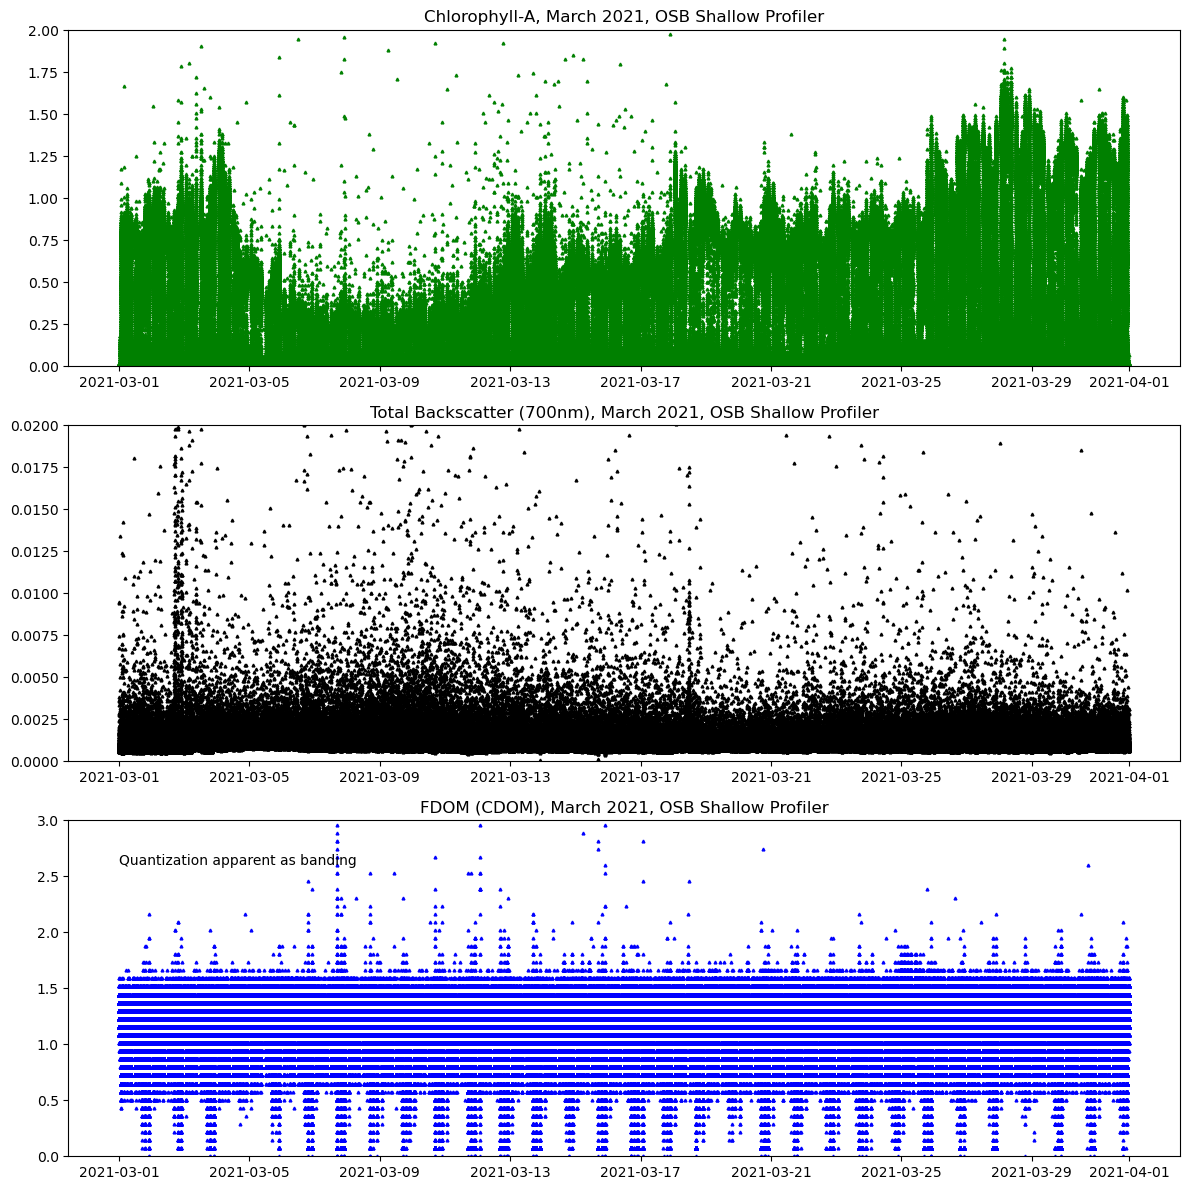

In [76]:
fig,axs=plt.subplots(3, figsize=(12,12), tight_layout=True)

axs[0].plot(D.time, D.chlora,       ms=2., marker='^', linestyle='None', color='g')
axs[1].plot(D.time, D.backscatter,  ms=2., marker='^', linestyle='None', color='k')
axs[2].plot(D.time, D.fdom,         ms=2., marker='^', linestyle='None', color='b')

axs[0].set(ylim=(0.0, 2.0), title='Chlorophyll-A, March 2021, OSB Shallow Profiler')
axs[1].set(ylim=(0.0, .02), title='Total Backscatter (700nm), March 2021, OSB Shallow Profiler')
axs[2].set(ylim=(0.0, 3.0), title='FDOM (CDOM), March 2021, OSB Shallow Profiler')

axs[2].text(dt64('2021-03-01'), 2.6, 'Quantization apparent as banding')

fig.show()

In [77]:
# Save figure 1 version 1: One month
fig.savefig("../BOS/Figures/BO_F1_1_March_2021_Scatter_x_3.png")

#### Reduce data time range to one day: 10-MAR-2021

In [78]:
D = D.sel(time=slice(dt64('2021-03-10'), dt64('2021-03-11')))

In [79]:
# Save
df = D.to_dataframe()
df = df.to_csv('../BOS/BO_F1_2_10_MAR_2021_full_resolution.csv')

Text(2021-03-10, 2.6, 'Banding due to sensor quantization')

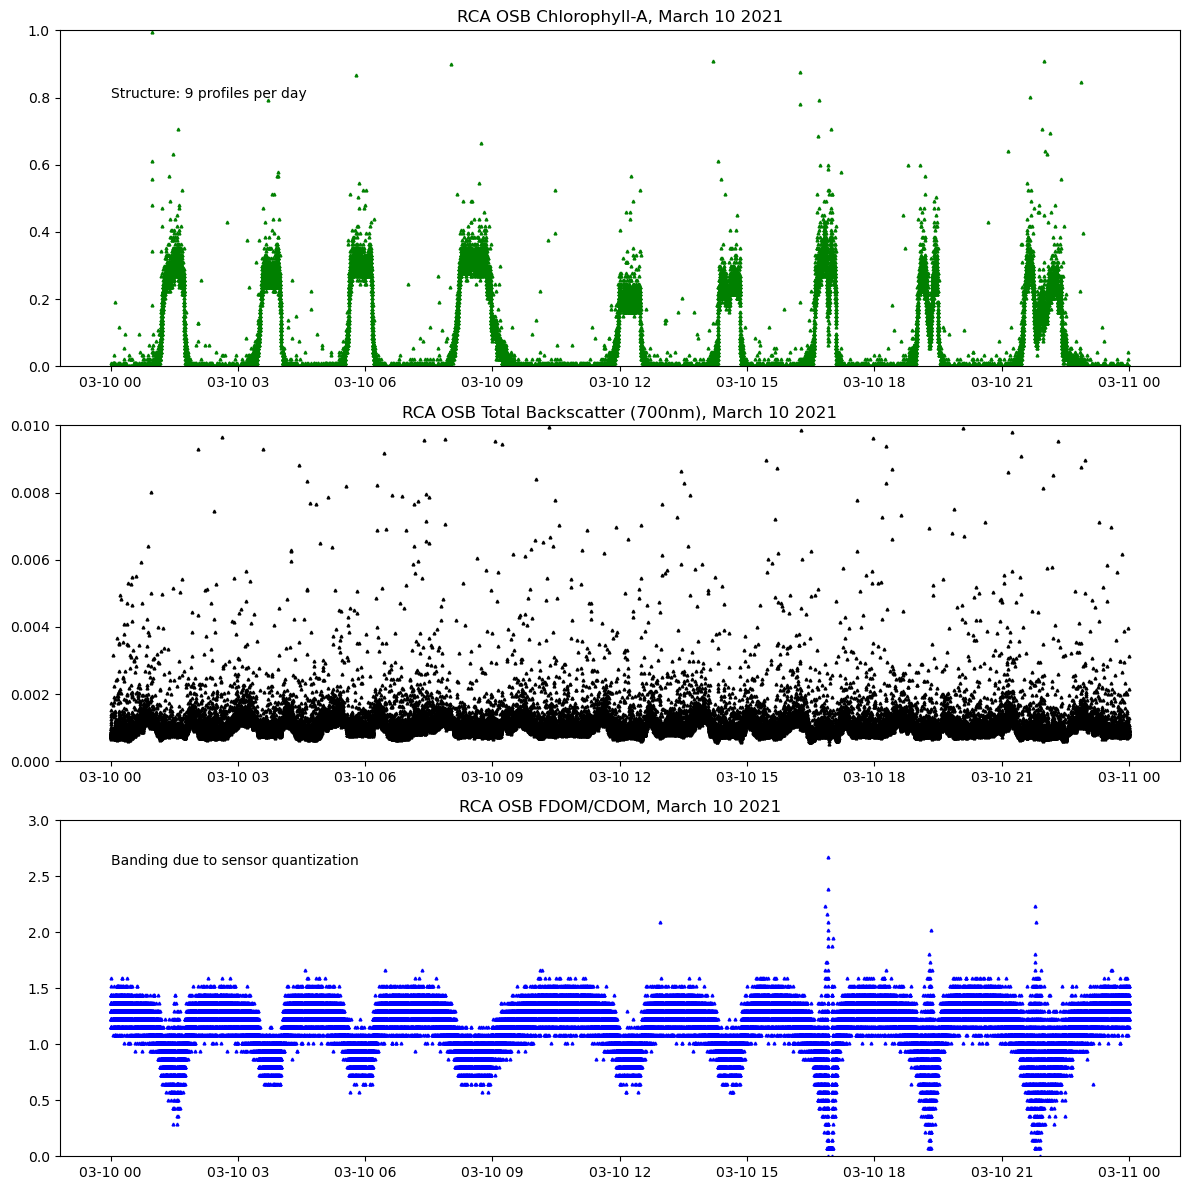

In [80]:
fig,axs=plt.subplots(3, figsize=(12,12), tight_layout=True)

axs[0].plot(D.time, D.chlora,       ms=2., marker='^', linestyle='None', color='g')
axs[1].plot(D.time, D.backscatter,  ms=2., marker='^', linestyle='None', color='k')
axs[2].plot(D.time, D.fdom,         ms=2., marker='^', linestyle='None', color='b')


axs[0].set(ylim=(0.0, 1.0), title='RCA OSB Chlorophyll-A, March 10 2021')
axs[1].set(ylim=(0.0, .01), title='RCA OSB Total Backscatter (700nm), March 10 2021')
axs[2].set(ylim=(0.0, 3.0), title='RCA OSB FDOM/CDOM, March 10 2021')

axs[0].text(dt64('2021-03-10'), 0.8, 'Structure: 9 profiles per day')
axs[2].text(dt64('2021-03-10'), 2.6, 'Banding due to sensor quantization')

In [81]:
# Save figure 1 version 2: 1 day
fig.savefig("../BOS/Figures/BO_F1_2_10_March_2021_Scatter_x_3.png")

### Remark: sample timing

The 'observation' coordinate is a simple counter. The 'time' coordinate/dimension consists of timestamps.
Time is the preferred dimension if multiple source data files come in to play as the ensemble is sortable
(whereas observation indices will be degenerate).


### Remark: QC flags


OOI QC or Quality Control flags are used to identify potential issues in time series data.
This primary reference is an online
[OOI guide to QC flags](https://oceanobservatories.org/knowledgebase/interpreting-qc-variables-and-results/). 


As an example for fluorometer data, the qc flag value for `fluorometric_cdom_qc_executed`
has value 29. This is interpreted as binary flags (right to left: `0b11101`) indicating
which tests have been applied to the stream data; hence tests 1, 3, 4 and 5 were completed. 
These are:

```
Bit 0: global_range_test
Bit 1: dataqc_localrangetest: Not completed
Bit 2: dataqc_spiketest
Bit 3: dataqc_polytrendtest
Bit 4: dataqc_stuckvaluetest
Bit 5: dataqc_gradienttest: Not completed
```

The corresponding QC flag `fluorometric_cdom_qc_results` indicates test *results*.

In [82]:
print('Decimal and binary cdom_qc_executed flag vlue:', 
      int(D.fluorometric_cdom_qc_executed[0]), 'or',
      bin(int(D.fluorometric_cdom_qc_executed[0])))

Decimal and binary cdom_qc_executed flag vlue: 29 or 0b11101


## Figure 2: Drop bad data


- global range test (part of QC flags): Is implemented here
- human in the loop (HITL): Is implemented but has no impact on the March 2021 dataset
- quality assurance for real-time OOI data (QARTOD): Is identified here but not implemented


Quality Control (QC) flags are included in the dataset on a sample-by-sample basis. 
The QC filter of interest here is the 'global range test' (bit 0 in the above remark). 


Human In The Loop (HITL) data are available through an `annotations.csv` file.


QA for Real Time OOI Data (QARTOD) are deferred at this time (2022). 


### Remark: FDOM/CDOM spikes


Spikes appear in the RCA OSB FDOM/CDOM data for March 2021, as shown in the 
example below for March 10. The global_range_test `_results` QC flag 
(the lowest order bit) is used to drop this spurious data.

In [83]:
# Save
df = D.fdom.to_dataframe()
df = df.to_csv('../BOS/BO_F2_1_10_MAR_2021_FDOMCDOM_before_QC.csv')

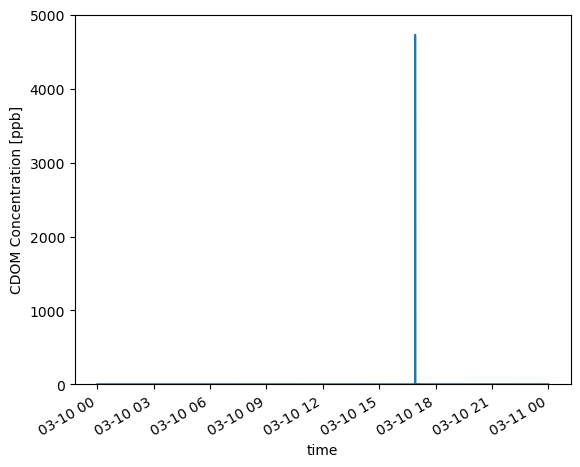

In [84]:
D.fdom.plot(ylim=(0, 5000))

In [85]:
# Not the DQG figure; not saved

In [86]:
# Break out from 'D' (the FLORT dataset) 3 Datasets called DA, DB, DC.
#   These are Chlor-A, Backscatter and FDOM/CDOM respectively.
#   The '% 2' in the code means modulo 2, i.e. a QC flag filter on bit zero.
#   The data value is retained only when the low order bit is 1.

DA = D.where(D.fluorometric_chlorophyll_a_qc_results % 2, drop=True)
DB = D.where(D.optical_backscatter_qc_results % 2,        drop=True)
DC = D.where(D.fluorometric_cdom_qc_results % 2,          drop=True)

In [87]:
# Save
df = DC[['fdom']].to_dataframe()
df = df.to_csv('../BOS/BO_F2_2_10_MAR_2021_FDOMCDOM_QC_applied.csv')

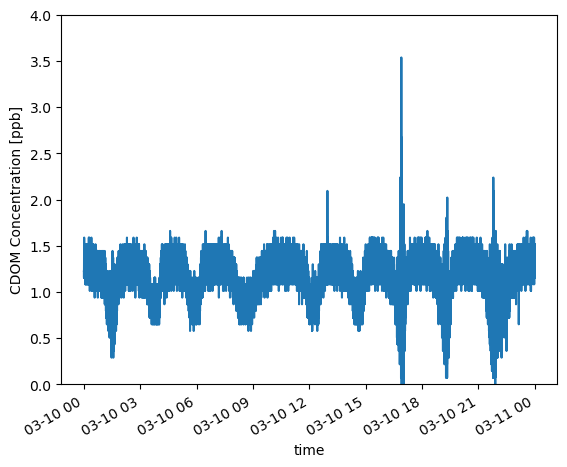

In [88]:
DC.fdom.plot(ylim=(0, 4))           # shows the egregious spike above has been dropped

#### A dual 'before/after' comparison chart is produced below.

Text(2021-03-10, 3.5, 'Data range 0 - 4')

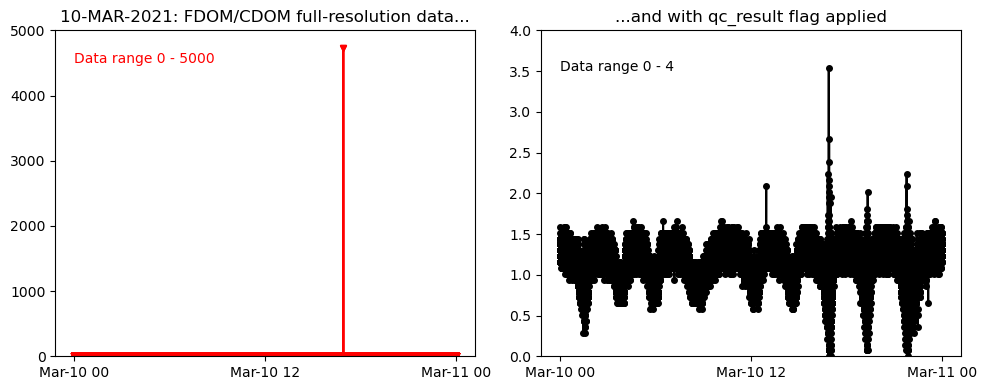

In [89]:
time_ticks = [dt64('2021-03-10'), dt64('2021-03-10 12'), dt64('2021-03-11')]

fig, axs = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

axs[0].plot(D.time, D.fdom,  ms=4., marker='v', color='r')
axs[1].plot(DC.time, DC.fdom,  ms=4., marker='o', color='k')

axs[0].set(ylim=(0.0, 5000.), title='10-MAR-2021: FDOM/CDOM full-resolution data...')
axs[1].set(ylim=(0.0, 4.0),   title='...and with qc_result flag applied')

axs[0].xaxis.set_ticks(time_ticks)
axs[1].xaxis.set_ticks(time_ticks)
           
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d %H'))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d %H'))

axs[0].text(dt64('2021-03-10'), 4500, 'Data range 0 - 5000', color='r')
axs[1].text(dt64('2021-03-10'), 3.5, 'Data range 0 - 4', color='k')

In [90]:
# Save figure 2
fig.savefig("../BOS/Figures/BO_F2_1_10_MAR_2021_FDOMCDOM_QC_applied.png")

### Remark: Other QC flags

The other QC tests (higher order bits in the `_qc_results` flag) indicate data *of interest*. 
These flags are not used to *drop* additional data. 

### Human In The Loop (HITL) annotation data


The OOI Data Explorer provides 
[annotation files](https://dataexplorer.oceanobservatories.org/#metadata/104289/station/187/sensor/annotations)
(CSV format) that can be used to interpret time-series data for specific arrays. 
These are spreadsheets that include date ranges and commentary.


The code below reads an `annotations` file specific to the RCA.
Owing to small file size this file has been located within this
repository. Date ranges are scanned 
to identify overlaps with a date range of interest, e.g. March 2021. 
When no overlaps are found, no action is taken. A date range scan 
from 2019 does turn up two annotation overlaps; so further
investigation is suggested in that case. 

In [91]:
print("2021")
CheckHITL('./HITLAnnotations/annotations_rca.csv', dt64('2021-03-01'), dt64('2021-04-01'))
print("\n2019")
CheckHITL('./HITLAnnotations/annotations_rca.csv', dt64('2019-03-01'), dt64('2019-09-01'))
print()

2021

No overlap between annotation record and time range of interest.


2019

 2 time overlaps: annotations vs time range of interest. Rows: [22, 29]
       2019-08-10T14:42:54  to  2019-08-24T08:45:45
       2019-06-24T19:03:08  to  2019-07-12T10:06:48




### Remark: Examining the 'annotations' data frame

The `annotations` CSV file is read into a pandas data frame. The dimensions 
of this data frame are given by `print(annot.shape)`. The cells below illustrate
remarks of interest.

In [92]:
annot = pd.read_csv('./HITLAnnotations/annotations_rca.csv')
print(annot.iloc[22]['annotation'])
print()
print(annot.iloc[29]['annotation'])

In August 2019 the platform experienced another major blow down event (~30 m deep), most likely due to strong currents. There was no indication of damage or other issue that could have caused the shift in location.

Following the 2019 deployment, the platform experienced a several-day, major blow down event (350 m west, 48 m deep), most likely due to strong currents. The platform and profiler pod were inspected by the Jason ROV, but there was no visual indication of damage or other issue that could have caused the shift in location.


#### The following code simplifies the datasets by dropping everything but the specified Data Variables. Coordinates including `depth` and `time` are retained.

In [93]:
DA = DA[['chlora']]
DB = DB[['backscatter', 'seawater_scattering_coefficient']]
DC = DC[['fdom']]

In [94]:
# Save
df = DA.to_dataframe()
df = df.to_csv('../BOS/BO_F2_3_10_MAR_2021_CHLORA_QC_applied.csv')
df = DB.to_dataframe()
df = df.to_csv('../BOS/BO_F2_4_10_MAR_2021_BACKSCATTER_QC_applied.csv')
df = DC.to_dataframe()
df = df.to_csv('../BOS/BO_F2_5_10_MAR_2021_FDOMCDOM_QC_applied.csv')

## Figure 3: Manual Intervention

The following code applies median and mean filters to Chlor-A data to reduce noise.

In [95]:
DA_median_20S = DA.resample(time='20S').median()
DA_mean_20S   = DA.resample(time='20S').mean()

In [96]:
# Save
df = DA_median_20S.to_dataframe()
df = df.to_csv('../BOS/BO_F3_1_10_MAR_2021_20S_median_filter.csv')
df = DA_mean_20S.to_dataframe()
df = df.to_csv('../BOS/BO_F3_2_10_MAR_2021_20S_mean_filter.csv')

Text(2021-03-10T08:24, 0.16, 'Mean filter (20 seconds): magenta')

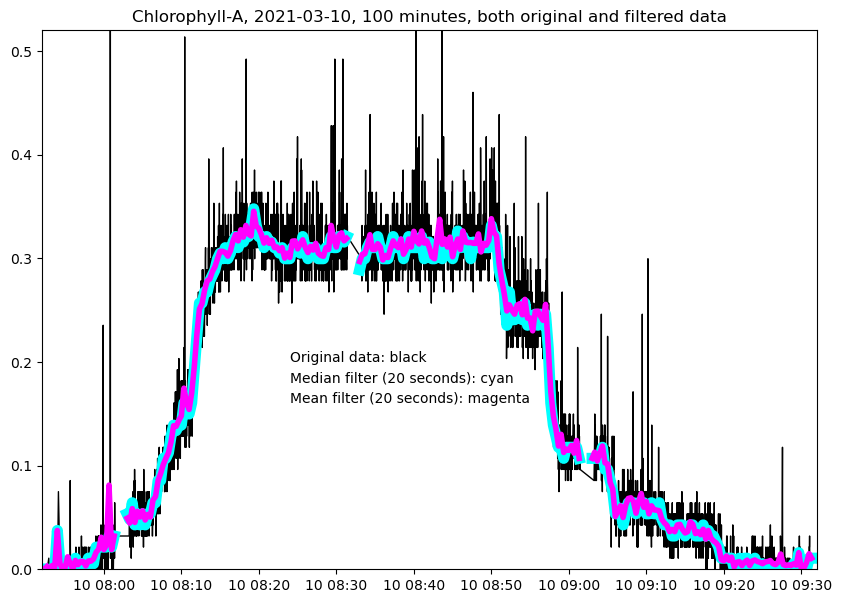

In [97]:
fig,ax=plt.subplots(figsize=(10,7))
ax.plot(DA.time, DA.chlora, color='k', lw=1)
ax.plot(DA_median_20S.time, DA_median_20S.chlora, color='cyan', lw=8)
ax.plot(DA_mean_20S.time, DA_mean_20S.chlora, color='magenta', lw=4)
ax.set(ylim=(-0.0, 0.52), xlim=(dt64('2021-03-10 07:52'), dt64('2021-03-10 09:32')), title='Chlorophyll-A, 2021-03-10, 100 minutes, both original and filtered data')
ax.text(dt64('2021-03-10 08:24'), 0.2, 'Original data: black', color='k')
ax.text(dt64('2021-03-10 08:24'), 0.18, 'Median filter (20 seconds): cyan', color='k')
ax.text(dt64('2021-03-10 08:24'), 0.16, 'Mean filter (20 seconds): magenta', color='k')

In [98]:
# Save figure 3
fig.savefig("../BOS/Figures/BO_F3_1_10_MAR_2021_Chlor_A_one_profile_filtered.png")

## Figure 4: Particulate backscatter

Calculated seawater scattering coefficient resides in the dataset. 
This is derived by OOI using temperature and salinity. 
Particulate backscatter is equal to the total backscatter less this seawater 
scattering coefficient. In terms of pseudo-code we have: 


```
Total optical backscatter ('bb', 700 nm) is an OOI level 2 product
Seawater backscatter coefficient is provided in this data product as well

FOR i: over bb values of interest, e.g. a time series
    seawater backscatter coefficient bb_sw(T, S) provided
    particulate backscatter bb_p(i) = bb(i) - bb_sw(i)
```

In [99]:
# Uses the Python lambda 'simple anonymous function' construction
DB = DB.assign(particulate = lambda DB: DB.backscatter - DB.seawater_scattering_coefficient)

In [100]:
# Save
df = DB.to_dataframe()
df = df.to_csv('../BOS/BO_F4_1_10_MAR_2021_Particulate_Backscatter_calculated.csv')

In [101]:
DB_micro = DB.sel(time=slice(dt64('2021-03-10 06:12'), dt64('2021-03-10 06:16')))

In [102]:
# Save
df = DB_micro.to_dataframe()
df = df.to_csv('../BOS/BO_F4_2_10_MAR_2021_Backscatter_4_minute_clip.csv')

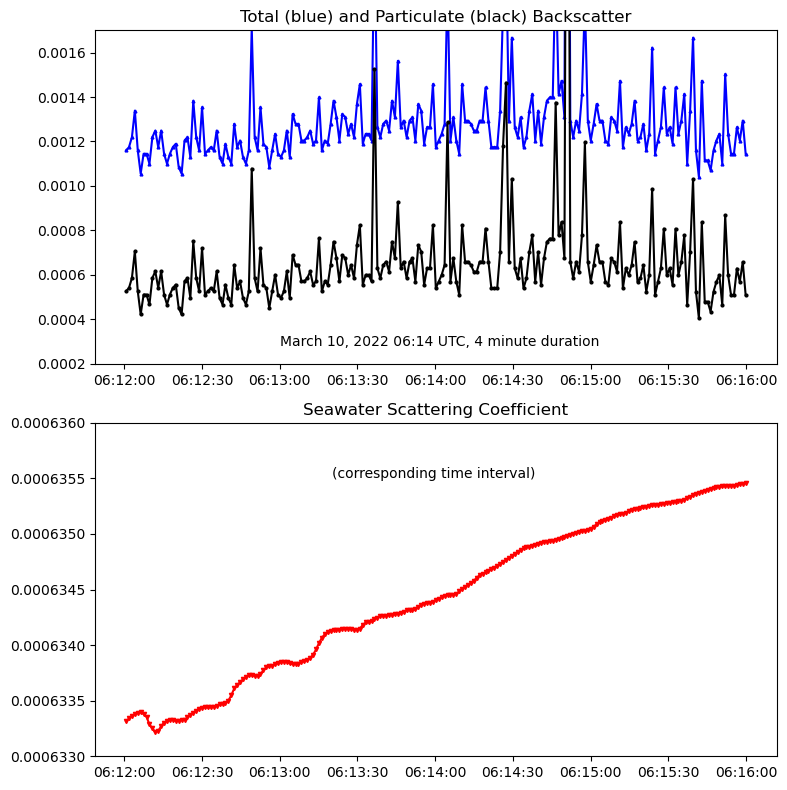

In [103]:
fig,axs=plt.subplots(2, figsize=(8,8), tight_layout=True)

axs[0].plot(DB_micro.time, DB_micro.backscatter,                     ms=2., marker='^', linestyle='-', color='b')
axs[0].plot(DB_micro.time, DB_micro.particulate,                     ms=2., marker='o', linestyle='-', color='k')
axs[0].set(ylim=(0.0002,     0.0017  ), title='Total (blue) and Particulate (black) Backscatter')

axs[1].plot(DB_micro.time, DB_micro.seawater_scattering_coefficient, ms=3., marker='v', linestyle='-', color='r')
axs[1].set(ylim=(0.000633,  0.000636 ), title='Seawater Scattering Coefficient')

axs[0].text(dt64('2021-03-10 06:13'), .00028, 'March 10, 2022 06:14 UTC, 4 minute duration')
axs[1].text(dt64('2021-03-10 06:13:20'), .0006355, '(corresponding time interval)')

fig.show()

#    ds_1day = ds.sel(time=slice(dt64(t0str), dt64(t1str)))   
#    fig, axs = plt.subplots(figsize=(12,4), tight_layout=True)   
#    axs.plot(ds_1day.time, ds_1day.z, marker='.', ms=9., color='k', mfc='r')   
#    axs.set(ylim = (-200., 0.), title=title)
#    axs.text(dt64('2021-02-28 23:15'), -184, 'AT')

In [104]:
# Save figure 4
fig.savefig("../BOS/Figures/BO_F4_1_10_MAR_2021_total_and_particulate_backscatter.png")

## Figure 5: Profiler Chlor-A dark correction

### Technical basis


Chlorophyll-A dark correction amounts to removing a constant bias from the data. 
This bias may be positive or negative and indicates a *de facto* non-zero signal
when it is assumed there is no fluorescing chlorophyll-a pigment to fluoresce.


Profiler data at depth -- say from some time interval within a deployment -- 
is used for dark bias calculation. This bias can be
subtracted from data for longer periods, up to the full instrument deployment. 


The code here proceeds in three phases: Aggregate, Estimate and Apply.


- Aggregate: Identify a small set (between 5 and 10) of correction profiles
- Estimate: Arrive at the constant bias from the correction profiles
- Apply: Subtract the bias from a larger set of profiles


Correction profiles extend 100 or more meters below the productive layer; which
is defined in *ad hoc* manner in what follows.



### Part 1: Aggregate


```
Loop over Profiles, index i
    max_z[i] = max depth, this profile
    max_chlora_z[i] = depth of chlorophyll maximum, this profile
    max_chlora[i] = chlorophyll max, this profile
    productive_layer_depth[i] = minimum z where:
                                    (z > max_chlora_z[i]) and
                                    (chlorophyll <= 0.1 x max_chlora[i])


Define an empty list: correction_profiles

To populate this list: Loop over profiles, index i
    if max_z[i] - productive_layer_depth[i] >= 100 meters:
        append profile i to the correction_profiles list        
```


### Part 2: Estimate


```
If number of correction profiles is less than 5: 
    ...insufficient basis; halt...
    
Loop over correction_profiles, index i
     chlorophyll_minima[i] = min(correction_profiles[i])

dark_correction = median(chlorophyll_minima)
dark_correction_standard_deviation = std(chlorophyll_minima)

Verify that the resulting correction values are self-consistent
```


### Part 3: Apply


```
Loop over all data of interest
    chlorophyll_dark_corrected = original_chlorophyll - dark_correction
```

In [105]:
#
# Re-load the OOI RCA OSB SP March 2021 dataset 
#
D = xr.open_dataset('../data/rca/fluor/osb/2021/flort_fullres.nc')
D = D.swap_dims({'obs':'time'})
D = D.sel(time=slice(dt64('2021-03-01'), dt64('2021-04-01')))
D = D.dropna('time')
D = D.rename( {'fluorometric_cdom':          'fdom',
               'fluorometric_chlorophyll_a': 'chlora',
               'optical_backscatter':        'backscatter'})

In [106]:
pl = ProfileListFromTimeWindow(p, dt64('2021-03-01'), dt64('2021-04-01'))
max_z, max_chlora_z, max_chlora, productive_layer_depth, correction_profiles = [], [], [], [], []

In [107]:
# Most profiles fit the candidate criteria so we scan only 20 or so
for i in pl[0:20]:

    # 'ascent' is a Dataset constrained in time to a shallow profiler ascent. 
    #   Filtered reduces intrinsic noise: 20-second window is typically 16 samples
    ascent = D.sel(time=slice(dt64(p['ascent_start'][i]), dt64(p['ascent_end'][i]))).resample(time='20S').mean() 
                   
    if len(ascent.time): 
        this_max_z, this_max_chlora, this_max_chlora_z = 0., 0., 0.
        for j in range(len(ascent.time)):
            chlora, depth = float(ascent.chlora[j]), float(ascent.int_ctd_pressure[j])
            if chlora > this_max_chlora: this_max_chlora, this_max_chlora_z = chlora, depth
            if depth > this_max_z:       this_max_z = depth
        max_z.append(this_max_z)
        max_chlora.append(this_max_chlora)
        max_chlora_z.append(this_max_chlora_z)

        this_productive_layer_depth = 999999
        for j in range(len(ascent.time)):
            chlora, depth = float(ascent.chlora[j]), float(ascent.int_ctd_pressure[j])
            if depth < this_productive_layer_depth and depth > max_chlora_z[-1] and chlora <= 0.1 * max_chlora[-1]:
                this_productive_layer_depth = depth
                
        productive_layer_depth.append(this_productive_layer_depth)
        if max_z[-1] - productive_layer_depth[-1] >= 100: correction_profiles.append(i)

#### Results of the Aggregate step

In [108]:
print('depth of first profile (m):', round(max_z[0], 1))
print('...of the productive layer (m):', round(productive_layer_depth[0], 1))
print('max chlorophyll for entire profile (ug/l):', round(max_chlora[0], 4))
print('depth at chlorophyll max: (m)', round(max_chlora_z[0], 1))

depth of first profile (m): 190.9
...of the productive layer (m): 85.3
max chlorophyll for entire profile (ug/l): 0.8007
depth at chlorophyll max: (m) 31.9


In [109]:
#
# Part 2: Estimate the dark correction value
#
dark_value_sum = 0.
chlora_minima = []
for i in correction_profiles:
    this_profile = D.sel(time=slice(dt64(p['ascent_start'][i]), dt64(p['ascent_end'][i]))).resample(time='20S').mean()
    this_minimum = 999999.
    for j in range(len(this_profile.time)):
        chlora = float(this_profile.chlora[j])
        if chlora < this_minimum: this_minimum = chlora
    chlora_minima.append(this_minimum)

dark_correction = np.median(chlora_minima)
dark_correction_std = np.std(chlora_minima)
print('dark correction constant (std):', round(dark_correction, 4), '(', round(dark_correction_std, 4), ')')

dark correction constant (std): -0.033 ( 0.0015 )


In [110]:
#
# Part 3: Apply dark correction to the full month of data in Dataset 'D'
#

print('Example: First chlora value from March 2021:', round(float(D.chlora[0]), 4), 'where dark correction to be subtracted is', round(dark_correction, 4))
Ddark = D.copy(deep=True)                                   # make a completely independent (deep = True) copy of D
Ddark.chlora[:] -= dark_correction                          # subtract the dark_correction bias
print('result:', round(float(Ddark.chlora[0]), 4))          # demonstrate the result for the first chlorophyll value

Example: First chlora value from March 2021: -0.0107 where dark correction to be subtracted is -0.033
result: 0.0223


In [111]:
D_hour_resampled     = D.sel(    time=slice(dt64('2021-03-10 05:12'), dt64('2021-03-10 06:30'))).resample(time='20S').mean() 
Ddark_hour_resampled = Ddark.sel(time=slice(dt64('2021-03-10 05:12'), dt64('2021-03-10 06:30'))).resample(time='20S').mean() 

In [112]:
# Save
df = D_hour_resampled.to_dataframe()
df = df.to_csv('../BOS/BO_F5_1_10_MAR_2021_One_Hour_Resampled_mean_20_seconds.csv')
df = D_hour_resampled.to_dataframe()
df = df.to_csv('../BOS/BO_F5_2_10_MAR_2021_One_Hour_Resampled_mean_20_seconds_dark_corrected.csv')

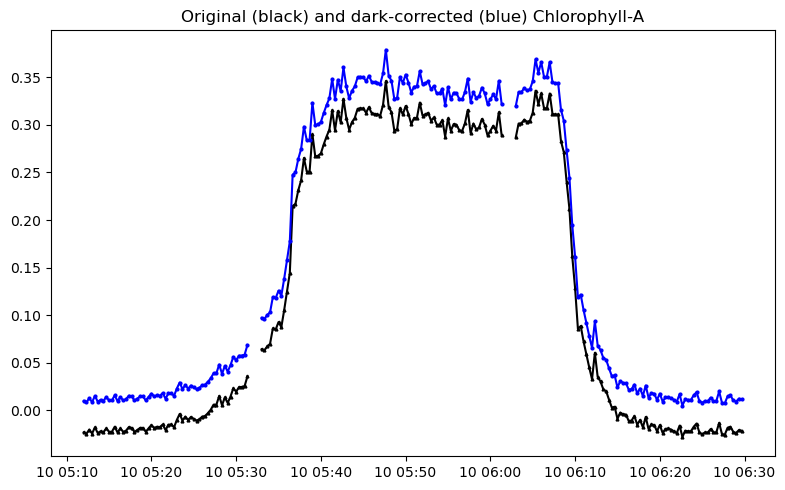

In [113]:
fig,ax=plt.subplots(figsize=(8,5), tight_layout=True)

ax.plot(D_hour_resampled.time, D_hour_resampled.chlora,         ms=2., marker='^', linestyle='-', color='k')
ax.plot(Ddark_hour_resampled.time, Ddark_hour_resampled.chlora, ms=2., marker='o', linestyle='-', color='b')
ax.set(title='Original (black) and dark-corrected (blue) Chlorophyll-A')

# axs[0].text(dt64('2021-03-10 06:13'), .00028, 'March 10, 2022 06:14 UTC, 4 minute duration')
# axs[1].text(dt64('2021-03-10 06:13:20'), .0006355, '(same time interval as above)')

fig.show()

In [114]:
# Save figure 5
fig.savefig("../BOS/Figures/BO_F5_1_10_MAR_2021_original_and_dark_corrected_chlor_a.png")

## Figure 6: Discrete sample comparison


### Remark: Discrete data 


Discrete data refers to water samples collected and analyzed for comparison
with *in situ* instrumentation, such as we have with the shallow profiler. 
Owing to logistical issues this analysis will be done using data from 2018.


#### Rosette casts during RCA VISIONS maintenance cruises

- RCA VISIONS cruise CTD casts near instrument sites
- Niskin bottle discrete samples trigger on ascent ('upcast') at a sequence of depths
    - [Rosettes](https://www.whoi.edu/what-we-do/explore/instruments/instruments-sensors-samplers/rosette-sampler/) support continuous measurements as well (1 sample / second)
- Discrete Summary files: CSV tables 
    - From the dedicated 'Alfresco' server; includes excerpted fluorometer data
    - [Alfresco browse site](https://alfresco.oceanobservatories.org/alfresco/faces/jsp/browse/browse.jsp)
        - Navigate: Cabled array > Cruise data > (year of choice) > Ship Data > Water Sampling
        - Example: **`Cabled-12_TN393_2021-07-30`**
        - TN: Thompson. AT: Atlantis. RR: Revelle. SKQ: Sikuliaq (2016)
        - 393: cruise number
        - Cabled-12: OOI Regional Cabled Array; 12 is an arbitrary index
        - OOI RCA background: 
            - VISIONS cruises use Newport OR as base of operations
            - Cruise is a series of four or five sorties or 'legs', each typically 5-10 days
            - 2021-07-30 is the cruise start date
        - In the Water Sampling folder:
            - **Cabled-12_TN393_Discrete_Summary-README.pdf** is the Users Guide
            - **Cabled-12_TN393_Discrete_Summary.csv** is the tabular **Discrete Summary**   
        - Cast reference site: **`SP`** is Shallow Profiler
        - Cast sequence: **`CTD-005`** is a CTD cast by index (skips are common)
        - Cast location: **`500m SW`** indicates an offset southwest (SW) from the SP position
    - **`DiscreteSummaries`** folder contains tabular data and metadata: 2015 - 2021
- By year: VISIONS casts near OSB SP
    - 2014--2017: None
    - 2018
        - CTD-002, 2018-06-26T20:23Z, 500m W
            - SP deployed Aug 4, 2017 through Jun 24, 2018 02:00Z
                - 2 days 18 hrs after SP stop
        - CTD-006, 2018-07-10T20:46Z, 250m W
        - CTD-008, 2018-07-10T22:44Z, 500m W (rapid succession)
            - SP deployed "briefly" Jun 24, 2018 through Jul 9, 2018 12:00Z
                - 34 hours after SP deployment
    - 2019
        - CTD-006, 2019-06-14T11:24Z,  250m W
            - SP deployed Jul 9, 2018 through Jun 14, 2019 05:26Z
                - The cast above on June 14 is 6 hours after SP stop (good candidate)
        - CTD-010, 2019-06-27T19:38Z,  250m W
    - 2020
        - CTD-001, 2020-08-03T15:18Z,    0m
            - SP deployed Jun 14, 2019 through Aug 2, 2020 19:41Z
                - The cast above on Aug 3 is 19 hours after SP stop
        - CTD-006, 2020-08-11T04:28Z, 1300m NE
        - CTD-007, 2020-08-11T05:48Z, 1300m NE
    - 2021
        - CTD-005, 2021-08-06T01:44Z, 500m SW
            - Aug 3, 2020 through Aug 4, 2021 20:20Z
                - The cast above on Aug 6 is 30 hours after SP stop

### Discrete Summary table column headers 

Column headers include:

```
Cruise, Station, Start Time [UTC], Cast;
    CTD Bottle Closure Time [UTC], CTD Depth [m];
    CTD Temperature 1 [deg C], CTD Temperature 2 [deg C];
    CTD Conductivity 1 [S/m], CTD Conductivity 2 [S/m];
    CTD Salinity 1 [psu], CTD Salinity 2 [psu];
    CTD Oxygen [mL/L];
    CTD Fluorescence [mg/m^3];
    CTD Beam Attenuation [1/m], CTD Beam Transmission [%];
    CTD pH;
    Discrete Oxygen [mL/L];
    Discrete Chlorophyll [ug/L];
    Discrete Nitrate [uM]
```

The modifier `CTD` indicates a continuously-running sensor affixed to the rosette frame. 
The modifier `Discrete` indicates an analysis of water recovered from a Niskin bottle. 
Below we include both `CTD Fluorescence` and `Discrete Chlorophyll` in comparison with
the Chlorophyll-A recorded by the shallow profiler. 


Cast CTD-002 is chosen, corresponding to three days after the end of the OSB SP 
deployment. (Full Discrete Summary table is 169 x 80.) The CTD-002 cast has 
17 depths (bottle closures) from 222 to 13 meters. However of these 17 only 7 
include a Chlor-A lab measurement.

In [115]:
# Read the Discrete Summary (CSV) table for Regional Cabled Array 2018

Discrete2018 = pd.read_csv('./DiscreteSummaries/RCA2018_RR_DiscSumm.csv')
Discrete002 = Discrete2018[Discrete2018["Cast"] == "CTD-002"]

# Additional OSB SP casts:
#   Discrete006 = Discrete2018[Discrete2018["Cast"] == "CTD-006"]
#   Discrete008 = Discrete2018[Discrete2018["Cast"] == "CTD-008"]
# Examine column headers:
#   Discrete002.keys()
# Depths/data for this cast: 
#   Discrete002['CTD Depth [m]'], Discrete002["Discrete Chlorophyll [ug/L]"]

In [116]:
D002_time            = Discrete002["CTD Bottle Closure Time [UTC]"]
D002_depth           = Discrete002["CTD Depth [m]"]                             # runs 200 ... 11 meters
D002_fluor           = Discrete002["CTD Fluorescence [mg/m^3]"]
D002_chlor           = Discrete002["Discrete Chlorophyll [ug/L]"]
D002_disc_fluor_flag = Discrete002["Discrete Fluorescence Flag"]
D002_disc_fluor_repl = Discrete002["Discrete Fluorescence Replicate Flag"]

Inspection code

```
# Depths and data values for the CTD-002 cast:
#     print(D002_depth, '\n', D002_fluor, '\n', D002_chlor)
#
# Corresponding Niskin bottle closure times:
#     print(D002_time)
#         1:  2018-06-26T20:42:14.000Z
#         17: 2018-06-26T21:02:44.000Z
```

- 2018 Oregon Slope Base comparison: Discrete samples relative to shallow profiler
    - Discrete Chlorophyll is the 'apples to apples' comparison
    - CTD Fluorescence is a potential source of comparison
- CTD-002 is the cast closest in time to an OSB SP profile  
    - Cast at 2018-06-26T20:23Z, 500m West of SP site
    - SP ascent start to descent end 2018-06-26 20:42:00 -- 2018-06-26 23:24:00
- Discrete Depths: (m) `182, 162, 82, 62, 42, 23, 13`: (ug/L) `0.025, 0.087, 0.030, 0.208, 0.483, 0.167, 0.103`
- CTD Depths (m): `222.098, 202.454, 181.966, 182.197, 162.401, 162.053, 141.856, 142.452, 121.544, 102.720, 82.232, 62.311, 42.482, 42.396, 22.990, 12.959, 13.200`
    - Data (mg/m^3): `0.0684, 0.0682, 0.0670, 0.0678, 0.0677, 0.0682, 0.0673, 0.0670, 0.0697, 0.0828, 0.2010, 0.6560, 1.9600, 1.8900, 0.3510, 0.2220, 0.2280`


In [117]:
# profile index 617 corresponds in time to the CTD-002 cast
p = ReadProfileMetadata('./Profiles/osb2018.csv')
# p['ascent_start'][617], p['descent_end'][617]

In [118]:
# Switching to data from June 2018

D = xr.open_dataset('../data/rca/fluor/osb/2018/flort_fullres.nc')
D = D.swap_dims({'obs':'time'})
D = D.dropna('time')
D = D.rename( {'fluorometric_cdom':          'fdom',
               'fluorometric_chlorophyll_a': 'chlora',
               'optical_backscatter':        'backscatter'})

print('N-Data for the 2018 RCA OSB SP data: ', len(D.time))
print('\nComparative context:')
print()
print('SP operational time range: 24-JUN-2018 UTC 17 hours to 09-JUL-2018 UTC 0 hours')
print('                 More precisely:', D.time[0].data, D.time[-1].data)
print()
print('SP profile time: Ascent start 26-JUN-2018 UTC 20 Hours 42 minutes')
print('                 Descent end  26-JUN-2018 UTC 23 Hours 24 minutes')
print('                   This is a typical noon extended-duration profile')
print()
print('Corresponding CTD-002 cast begins 26-JUN-2018 UTC 20 Hours 23 minutes')
print('                 This is effectively simultaneous with the SP profile')
print()

N-Data for the 2018 RCA OSB SP data:  1029224

Comparative context:

SP operational time range: 24-JUN-2018 UTC 17 hours to 09-JUL-2018 UTC 0 hours
                 More precisely: 2018-06-24T16:49:59.587803136 2018-07-09T00:13:01.575661056

SP profile time: Ascent start 26-JUN-2018 UTC 20 Hours 42 minutes
                 Descent end  26-JUN-2018 UTC 23 Hours 24 minutes
                   This is a typical noon extended-duration profile

Corresponding CTD-002 cast begins 26-JUN-2018 UTC 20 Hours 23 minutes
                 This is effectively simultaneous with the SP profile



In [119]:
t0, t1 = p['ascent_start'][617], p['descent_end'][617]
print('Time from pre-calculated profiles:', t0, t1)
t0, t1 = dt64('2018-06-26 20:42'), dt64('2018-06-26 23:36')
print('Slightly adjusted:                ', t0, '  ', t1)

D = D.sel(time=slice(t0, t1))    
DA = D.where(D.fluorometric_chlorophyll_a_qc_results % 2, drop=True)      # qc_results flag applied
DA = DA[['chlora']]                         

print('\nN-Data for Chlor-A profile:', len(DA.time))

Time from pre-calculated profiles: 2018-06-26 20:42:00 2018-06-26 23:24:00
Slightly adjusted:                 2018-06-26T20:42    2018-06-26T23:36

N-Data for Chlor-A profile: 8681


In [120]:
# Save
df = DA.to_dataframe()
df = df.to_csv('../BOS/BO_F6_1_26_JUN_2018_Noon_Profile.csv')

Text(0.5, 1.0, 'Profile depth (meters) with time')

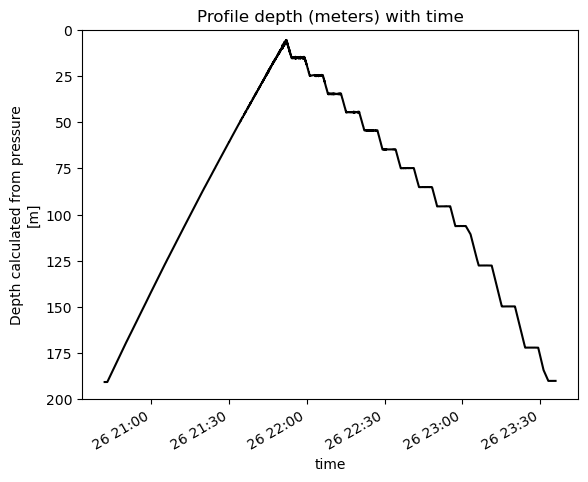

In [121]:
fig=DA.depth.plot(ylim=(200., 0.))[0]
fig.set(color='black')
plt.title('Profile depth (meters) with time')

In [122]:
# Figure for verification check; not saved

Text(0.5, 1.0, 'Chlorophyll-A concentration (ug/L) with time')

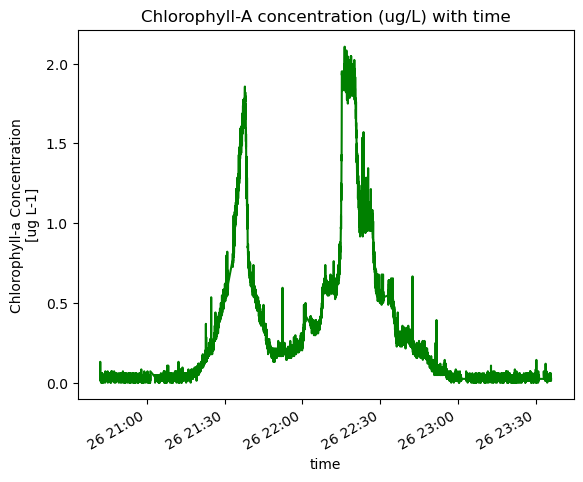

In [123]:
fig=DA.chlora.plot()[0]
fig.set(color='green')
plt.title('Chlorophyll-A concentration (ug/L) with time')

In [124]:
# Figure for verification check; not saved

In [125]:
# From the Discrete Summary table
depth_bounds = [0., 15., 30., 50., 70., 90., 110., 130., 150., 170., 190., 250.]    
depth_labels = [10., 20., 40, 60., 80., 100., 120., 140., 160., 180., 200.]

In [126]:
DA_median_20S = DA.resample(time='20S').median()
DA_mean_20S   = DA.resample(time='20S').mean()
DA_std_20S    = DA.resample(time='20S').std()

DA_mean_depth   = DA.sortby('depth').groupby_bins('depth', depth_bounds, labels=depth_labels).mean()
DA_median_depth = DA.sortby('depth').groupby_bins('depth', depth_bounds, labels=depth_labels).median()
DA_std_depth    = DA.sortby('depth').groupby_bins('depth', depth_bounds, labels=depth_labels).std()

In [127]:
# save
#
#

Time series charts for June 26, 2018 noon profile

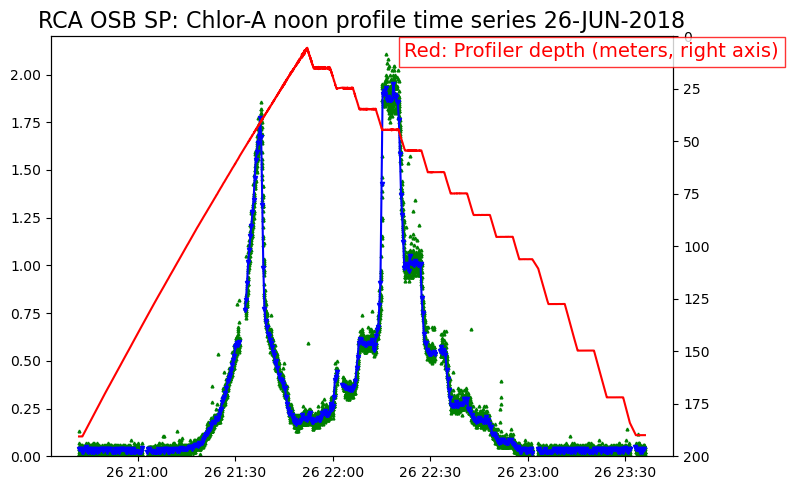

In [66]:
fig,ax=plt.subplots(figsize=(8,5), tight_layout=True)

ax.plot(DA.time, DA.chlora,                       ms=2., marker='^', linestyle='None', color='g')
ax.plot(DA_median_20S.time, DA_median_20S.chlora, ms=3., marker='v',                   color='b')
ax.set(ylim=(0.0, 2.2))
ax.set_title('RCA OSB SP: Chlor-A noon profile time series 26-JUN-2018', fontsize=16)

axtwin = ax.twinx()
axtwin.plot(DA.time, DA.depth, markersize = 4., color='red')
axtwin.set(ylim = (200, 0))

text_object = axtwin.text(dt64('2018-06-26 22:22'), 10, 'Red: Profiler depth (meters, right axis)', color='red', fontsize=14)
text_object.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='red'))

fig.show()

In [67]:
# Save figure 6
fig.savefig("../BOS/Figures/BO_F6_1_26_JUN_2018_noon_profile_chlor_a_time_series.png")

### Remark: Interpretation of data features


There are two features of interest in the above chart. The first is 
the step-wise nature of the time-series data in the right portion
of the chart. This is due to intentional pauses in the profiler
descent (steps in the red line) which are made to give the nitrate
sensor time to equilibrate.


The second feature is the Chlorphyll-A maximum at 40 to 45 meters,
seen in both the ascent and descent phases of the time series profile. 
When the profiler is at shallower depths, to as close as 10 meters 
from the ocean surface, the chlorophyll signal is noticeably attenuated.
This may be due to non-photochemical quenching (NPQ): To dissipate
excess excitation energy, chlorophyll pigments are chemically
altered by their host organisms to a state of non-radiative decay. 


Following figure: Depth-binned profile values in comparison to two
types of data from the Discrete Summary table: Discrete Chlor-A samples
and CTD Fluorescence.

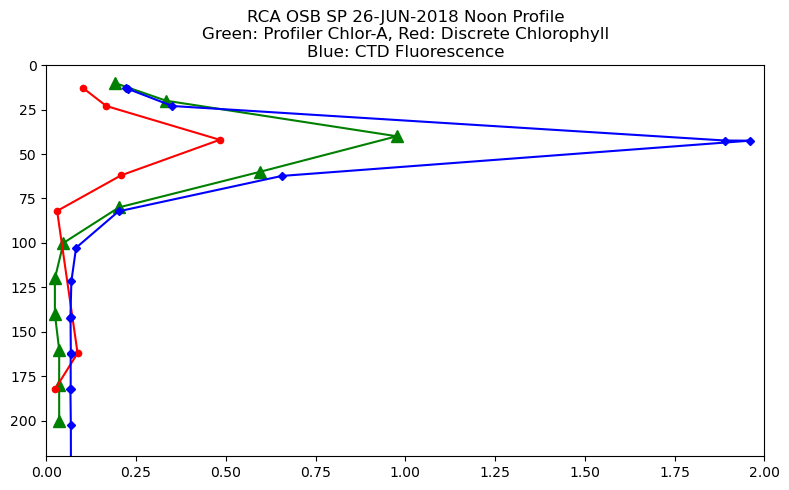

In [70]:
fig,ax=plt.subplots(figsize=(8,5), tight_layout=True)

# ax.errorbar(DA_median_depth.chlora,           DA_median_depth.depth_bins,  
#             xerr=DA_median_depth.chlora, ecolor='k', elinewidth=1, capsize=3,
#             ms=9., marker='^', linestyle='-', color='g')

# Values adopted from the Discrete Summary table
Discrete_Depth =  [182, 162, 82, 62, 42, 23, 13]
Discrete_ChlorA = [0.025, 0.087, 0.030, 0.208, 0.483, 0.167, 0.103]

ax.plot(DA_median_depth.chlora, DA_median_depth.depth_bins, ms=9., marker='^', linestyle='-', color='g')
ax.plot(Discrete_ChlorA, Discrete_Depth, marker='.', ms=9, color='r')
ax.plot(D002_fluor, D002_depth, marker='D', ms=4, color='b')

ax.set(ylim=(220., 0.), xlim=(0, 2.0), 
       title='RCA OSB SP 26-JUN-2018 Noon Profile\nGreen: Profiler Chlor-A, Red: Discrete Chlorophyll\nBlue: CTD Fluorescence')

fig.show()

In [71]:
# Save figure 6
fig.savefig("../BOS/Figures/BO_F6_2_26_JUN_2018_noon_profile_chlor_a_discrete_and_CTD_comparison.png")

### Remark: Interpretation

A chlorophyll maximum at 40 meters depth is neither unheard of or commonplace. The fact that 
it registeres in all three signals is a good indication of relative reliability. However
the disparity between the maxima suggests that absolute calibration is unresolved. The
CTD Fluorescence (blue) is a fluorometer attached to the rosette that runs 
continuously during the cast and is subsequently discretized. It is not clear
what wavelengths it uses.